In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 显示中文
plt.rcParams['axes.unicode_minus'] = False # 显示负号

# 1.导入并查看数据

In [3]:
data2016 = pd.read_excel('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/附件1.xlsx', sheet_name='2016')

In [4]:
data2016

,年,月,日,时间,水位(m),流量(m3/s),含沙量(kg/m3)
0,2016.0,1.0,1.0,0:00,42.79,357,0.825
1,NaN,NaN,NaN,4:00,42.80,363,NaN
2,NaN,NaN,NaN,8:00,42.80,363,0.796
3,NaN,NaN,NaN,12:00,42.81,368,NaN
4,NaN,NaN,NaN,14:00,42.84,384,NaN
...,...,...,...,...,...,...,...
2375,NaN,NaN,NaN,2:00,42.19,217,NaN
2376,NaN,NaN,NaN,8:00,42.19,217,0.356
2377,NaN,NaN,NaN,14:00,42.17,213,NaN
2378,NaN,NaN,NaN,20:00,42.18,215,NaN


In [5]:
data2017 = pd.read_excel('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/附件1.xlsx', sheet_name='2017')
data2018 = pd.read_excel('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/附件1.xlsx', sheet_name='2018')
data2019 = pd.read_excel('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/附件1.xlsx', sheet_name='2019')
data2020 = pd.read_excel('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/附件1.xlsx', sheet_name='2020')
data2021 = pd.read_excel('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/附件1.xlsx', sheet_name='2021')

In [6]:
DfList = [data2016, data2017, data2018, data2019, data2020, data2021]
for df in dataframeList:
    df.rename(columns={'年': 'year', '月':'month', '日':'day', '时间':'time',
                       '水位(m)':'waterLevel','流量(m3/s)':'flow','含沙量(kg/m3) ': 'sand'}, inplace = True)

In [7]:
data16 = data2016.copy()
data17 = data2017.copy()
data18 = data2018.copy()
data19 = data2019.copy()
data20 = data2020.copy()
data21 = data2021.copy()

In [8]:
data16.rename(columns={'含沙量(kg/m3)': 'sand'})

,year,month,day,time,waterLevel,flow,sand
0,2016.0,1.0,1.0,0:00,42.79,357,0.825
1,NaN,NaN,NaN,4:00,42.80,363,NaN
2,NaN,NaN,NaN,8:00,42.80,363,0.796
3,NaN,NaN,NaN,12:00,42.81,368,NaN
4,NaN,NaN,NaN,14:00,42.84,384,NaN
...,...,...,...,...,...,...,...
2375,NaN,NaN,NaN,2:00,42.19,217,NaN
2376,NaN,NaN,NaN,8:00,42.19,217,0.356
2377,NaN,NaN,NaN,14:00,42.17,213,NaN
2378,NaN,NaN,NaN,20:00,42.18,215,NaN


# 2.数据预处理

## 2.1 填补空值

填补空值方便后续的数据处理，在Excel中查看数据可知，时间、水位、流量三列数据都没有空缺值；年月日按照前一个非空值填充，含沙量在时间8：00都有数据，因此在每一天的含沙量空值处填充该日8：00的含沙量数据。

In [9]:
dataframeList = [data16, data17, data18, data19, data20, data21]

In [10]:
# 填充年月日三列
for df in dataframeList:
    df[['year','month','day']] = df[['year','month','day']].fillna(method='ffill')

In [11]:
# 填充含沙量
for df in dataframeList:
    # 遍历月份
    for i in df['month'].unique():
        # 遍历日期
        for j in df[df['month']==i]['day'].unique():
            x = df[(df['month']==i) & (df['day']==j) & (df['time']=='8:00')]
            y = x.iloc[:,6].values
            # 如果y是空值，那么取当月的含沙量均值
            if np.isnan(y) or not y:
                y = df[df['month']==i]['sand'].mean()
            df.loc[df[(df['month']==i)&(df['day']==j)].index,'sand'] = df.loc[df[(df['month']==i)&(df['day']==j)].index,'sand'].fillna(value = float(y))

C:\Users\liang\AppData\Local\Temp\ipykernel_6320\3240623323.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df.loc[df[(df['month']==i)&(df['day']==j)].index,'sand'] = df.loc[df[(df['month']==i)&(df['day']==j)].index,'sand'].fillna(value = float(y))
C:\Users\liang\AppData\Local\Temp\ipykernel_6320\3240623323.py:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.isnan(y) or not y:


# 3.建立模型

## 3.1 问题1

### 研究水文站黄河水的含沙量与时间、水位、水流量的关系，并估算出近 6 年该水文站的年总水流量和年总排沙量。

a.绘制含沙量与时间、水位、水流量的关系图

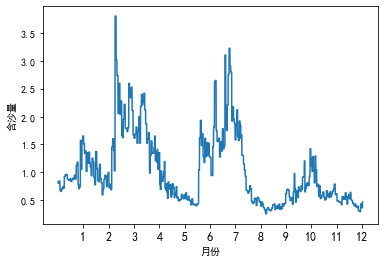

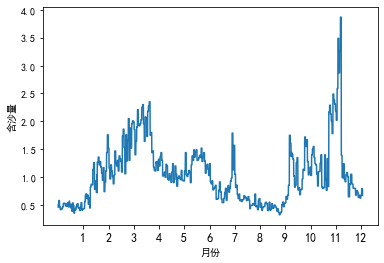

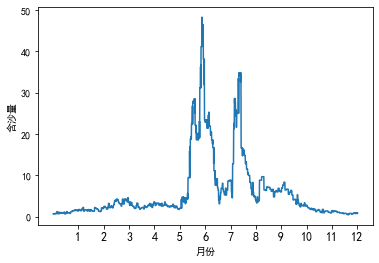

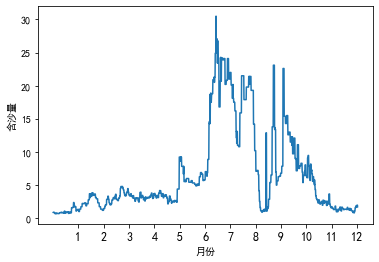

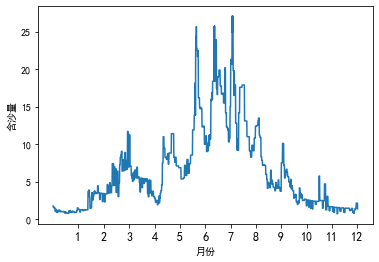

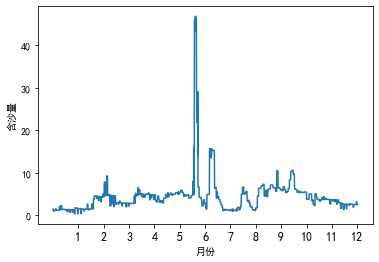

In [12]:
Y = 2016
for df in dataframeList:
    plt.figure()
    ax = plt.subplot()
    n = df.shape[0]
    ax.plot(np.arange(1, n+1), df['sand'])
    # ticks在原数据的范围内,设定主刻度的位置
    ax.set_xticks([n//12, (n//12)*2, (n//12)*3, (n//12)*4, (n//12)*5, (n//12)*6, (n//12)*7,(n//12)*8,(n//12)*9,(n//12)*10,(n//12)*11,(n//12)*12])
    # 设置主刻度的标签， 带入主刻度旋转角度和字体大小参数
    ax.set_xticklabels(['1', '2','3', '4', '5','6','7','8','9','10','11','12'], fontsize=12)
    ax.set_xlabel('月份')
    ax.set_ylabel('含沙量')
    ax.figure.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/sand_vs_time'+str(Y)+'.png')
    Y += 1

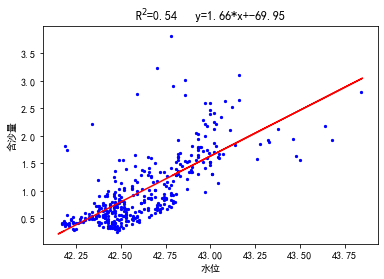

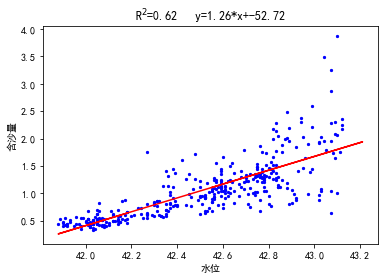

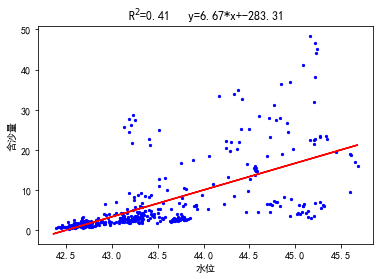

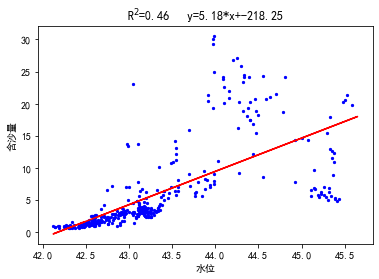

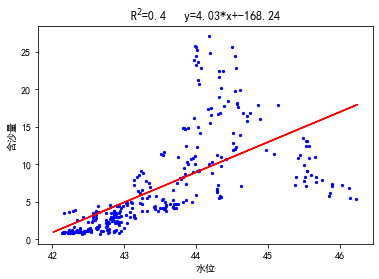

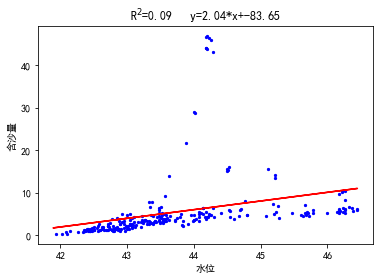

In [13]:
Y = 2016
DfList = [data2016, data2017, data2018, data2019, data2020, data2021]
for df in DfList:
    plt.figure()
    ax = plt.subplot()
    n = df.shape[0]
    data = df[df['sand'].notnull()]
    #对散点数据进行线性拟合 获取斜率 截距 R2
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['waterLevel'].values, data['sand'].values) #斜率 截距 R2
    #画拟合线
    xmax = max(df['waterLevel'].values)
    ymax = max(df['sand'].values)
    X1 = df['waterLevel']
    Y1 = np.array([ intercept+ slope * x for x in X1])
    ax.plot(X1,Y1, c='r')
    ax.scatter(df['waterLevel'], df['sand'],s=5,c='b')
    # ticks在原数据的范围内,设定主刻度的位置
    #ax.set_xticks([n//12, (n//12)*2, (n//12)*3, (n//12)*4, (n//12)*5, (n//12)*6, (n//12)*7,(n//12)*8,(n//12)*9,(n//12)*10,(n//12)*11,(n//12)*12])
    # 设置主刻度的标签， 带入主刻度旋转角度和字体大小参数
    #ax.set_xticklabels(['1', '2','3', '4', '5','6','7','8','9','10','11','12'], fontsize=12)
    ax.set_xlabel('水位')
    ax.set_ylabel('含沙量')
    ax.set_title('R$^2$=%s'%(np.around(r_value**2,2))+'   y=%s*x+%s'%(np.around(slope,2),np.around(intercept,2)))
    #ax.text(xmax*0.98, ymax*0.9,'R$^2$=%s'%(np.around(r_value**2,2)),fontsize=15)
    #ax.text(xmax*0.95, ymax*0.8,'y=%s*x+%s'%(np.around(slope,2),np.around(intercept,2)),fontsize=15)
    ax.figure.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/sand_vs_waterlevel'+str(Y)+'.png')
    Y += 1

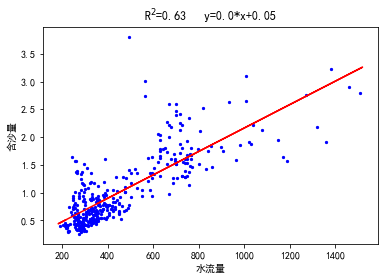

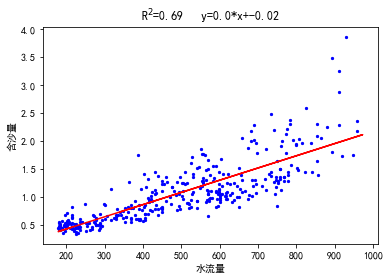

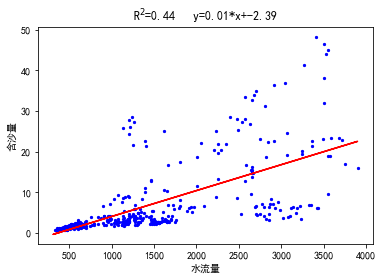

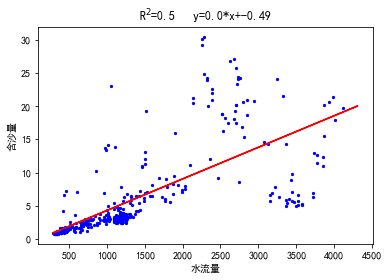

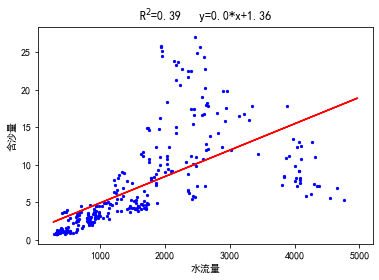

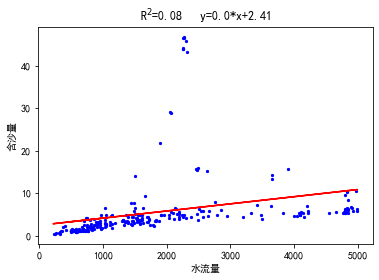

In [14]:
Y = 2016
DfList = [data2016, data2017, data2018, data2019, data2020, data2021]
for df in DfList:
    plt.figure()
    ax = plt.subplot()
    n = df.shape[0]
    data = df[df['sand'].notnull()]
    #对散点数据进行线性拟合 获取斜率 截距 R2
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['flow'].values, data['sand'].values) #斜率 截距 R2
    #画拟合线
    xmax = max(df['flow'].values)
    ymax = max(df['sand'].values)
    X1 = df['flow']
    Y1 = np.array([ intercept+ slope * x for x in X1])
    ax.plot(X1,Y1, c='r')
    ax.scatter(df['flow'], df['sand'],s=5,c='b')
    # ticks在原数据的范围内,设定主刻度的位置
    #ax.set_xticks([n//12, (n//12)*2, (n//12)*3, (n//12)*4, (n//12)*5, (n//12)*6, (n//12)*7,(n//12)*8,(n//12)*9,(n//12)*10,(n//12)*11,(n//12)*12])
    # 设置主刻度的标签， 带入主刻度旋转角度和字体大小参数
    #ax.set_xticklabels(['1', '2','3', '4', '5','6','7','8','9','10','11','12'], fontsize=12)
    ax.set_xlabel('水流量')
    ax.set_ylabel('含沙量')
    ax.set_title('R$^2$=%s'%(np.around(r_value**2,2))+'   y=%s*x+%s'%(np.around(slope,2),np.around(intercept,2)))
    #ax.text(xmax*0.98, ymax*0.9,'R$^2$=%s'%(np.around(r_value**2,2)),fontsize=15)
    #ax.text(xmax*0.95, ymax*0.8,'y=%s*x+%s'%(np.around(slope,2),np.around(intercept,2)),fontsize=15)
    ax.figure.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/sand_vs_flow'+str(Y)+'.png')
    Y += 1

b. 估算出近 6 年该水文站的年总水流量和年总排沙量

总水流量和总排沙量估计.含沙量的观测数据相对水位和流量观测数据存在大量缺失，为了更准确地评估总排沙量，使用线性插值补全缺失的含沙量观测数据.另外，为了控制每天观测次数的不同对总水流量和排沙量的影响，使用每天观测值的均值代表当天的观测值.

In [15]:
df_eval = pd.DataFrame(columns=['flow','sand'])

In [16]:
Y = 2016
for df in dataframeList:
    x = sum(df.groupby(['month','day'])['sand'].mean()* df.groupby(['month','day'])['flow'].mean())
    x = x*24*60*60
    y = sum(df.groupby(['month','day'])['flow'].mean())
    y = y*24*60*60
    df_eval.loc[str(Y), :] = [y, x]
    Y += 1

In [17]:
df_eval

,flow,sand
2016,14388181097.142859,18320411517.590199
2017,15344285279.999992,19014017811.776192
2018,38913777991.537071,291951773951.279297
2019,38744230204.032692,305080929452.203796
2020,43364584310.169823,349449647311.432312
2021,47288281715.923203,229284633887.402008


In [295]:
df_eval.to_csv('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/df_eval.csv', encoding='utf-8')

补充：每年含沙量的均值

In [17]:
for df in DfList:
    x = df['sand'].mean()
    print(x)

1.0125388739946393
1.045075268817204
6.544062499999996
5.764477722772276
6.99158255451713
5.502758754863815


## 3.2 问题2

### 分析近 6 年该水文站水沙通量的突变性、季节性和周期性等特性，研究水沙通量的变化规律。

(a) 水沙通量的突变性

In [19]:
x = np.arange(2016, 2022)

In [20]:
def MK(x, y, st):
    # st:检验的变量名称
    n = len(y)
    # 正序计算
    # 定义累计量序列Sk，长度n，初始值为0
    Sk = np.zeros(n)
    UFk = np.zeros(n)

    # 定义Sk序列元素s
    s = 0

    for i in range(1, n):
        for j in range(0,i):
            if y.iloc[i] > y.iloc[j]:
                s += 1
        Sk[i] = s
        E = (i+1)*(i/4)
        Var = (i+1)*i*(2*(i+1)+5)/72
        UFk[i] = (Sk[i] - E)/np.sqrt(Var)

    # 逆序计算
    # 定义逆累计量序列Sk2
    # 定义逆统计量序列Sk2
    y2 = np.zeros(n)
    Sk2 = np.zeros(n)
    UBk = np.zeros(n)

    s = 0
    y2 = y[::-1]

    for i in range(1, n):
        for j in range(0,i):
            if y2.iloc[i] > y2.iloc[j]:
                s += 1
        Sk2[i] = s
        E = (i+1)*(i/4)
        Var = (i+1)*i*(2*(i+1)+5)/72
        UBk[i] = -(Sk2[i] - E)/np.sqrt(Var)

    UBk2 = UBk[::-1]


    # 画图
    plt.figure()
    plt.plot(range(6),UFk, label='UF', color='b',marker='s')
    plt.plot(range(6), UBk2, label='UB',color='g', linestyle='--', marker='o')
    plt.ylabel('Mann-Kendall检验值')
    plt.xlabel('年份')

    # 添加辅助线
    x_lim = plt.xlim()
    # 添加显著水平线和y=0
    plt.plot(x_lim,[-1.96,-1.96],':',color='r',label='5%显著水平')
    plt.plot(x_lim, [0,0],'--',color='r')
    plt.plot(x_lim,[1.96,1.96],':',color='r')
    plt.xticks(range(6), x.tolist())
    # plt.legend(loc='upper right', bbox_to_anchor=(0.9,0.95),ncol=3,fancybox=True)

    # 设置图例位置，第一个参数调整左右位置，第二个参数调整上下位置
    plt.legend(bbox_to_anchor=(0.82,0.11), facecolor='w',frameon=False)
    # 添加文本注释
    plt.text(0,-1.6,'突变点检验')
    plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/MK检验'+st+'.png',dpi=350)
    plt.show()

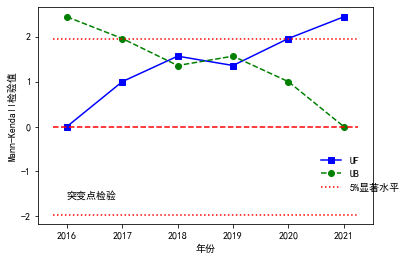

In [21]:
# 检验水流量
MK(x, df_eval['flow'], 'flow')

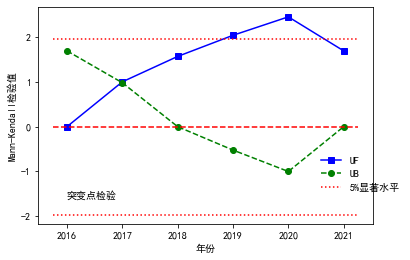

In [22]:
# 检验排沙量
MK(x, df_eval['sand'], 'sand')

(b) 分析水沙通量季节性

In [34]:
dataframeList = [data16, data17, data18, data19, data20, data21]

In [118]:
Df1 = pd.DataFrame()
for df in dataframeList:
    x = pd.DataFrame(df.groupby(['month'])['sand'].mean()*df.groupby(['month'])['flow'].mean())
    Df1 = pd.concat([Df1, x])
Df1.index = pd.Series(pd.date_range('2016-01', periods=12*6, freq='M'))
Df2 = pd.DataFrame(columns=['flow'])
for df in dataframeList:
    x = pd.DataFrame(df.groupby(['month'])['flow'].mean())
    Df2 = pd.concat([Df2, x])
Df2.index = pd.Series(pd.date_range('2016-01', periods=12*6, freq='M'))

In [119]:
Df1.columns=['sand']

In [24]:
def seasonal_mul(data, st):
    # st：变量名称，字符串类型
    from statsmodels.tsa.seasonal import seasonal_decompose

    result_mul = seasonal_decompose(data, model='multiplicative', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (10, 10)})
    result_mul.plot()
    plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/'+st+'_multiplicative.png')
    plt.show()

In [61]:
# 获取趋势、季节、残差值
trend = result_mul.trend
seasonal = result_mul.seasonal
residual = result_mul.resid

In [25]:
def seasonal_add(data, st):
    # st：变量名称，字符串类型
    from statsmodels.tsa.seasonal import seasonal_decompose

    result_add = seasonal_decompose(data, model='additive', extrapolate_trend='freq')
    plt.rcParams.update({'figure.figsize': (10, 10)})
    result_add.plot()
    plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/'+st+'_additive.png')
    plt.show()

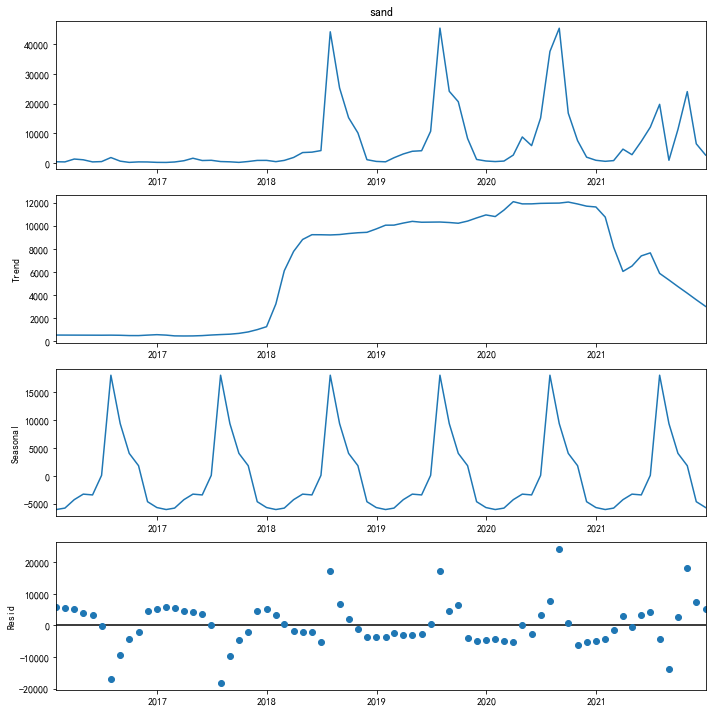

In [42]:
seasonal_add(Df1['sand'], 'sand')

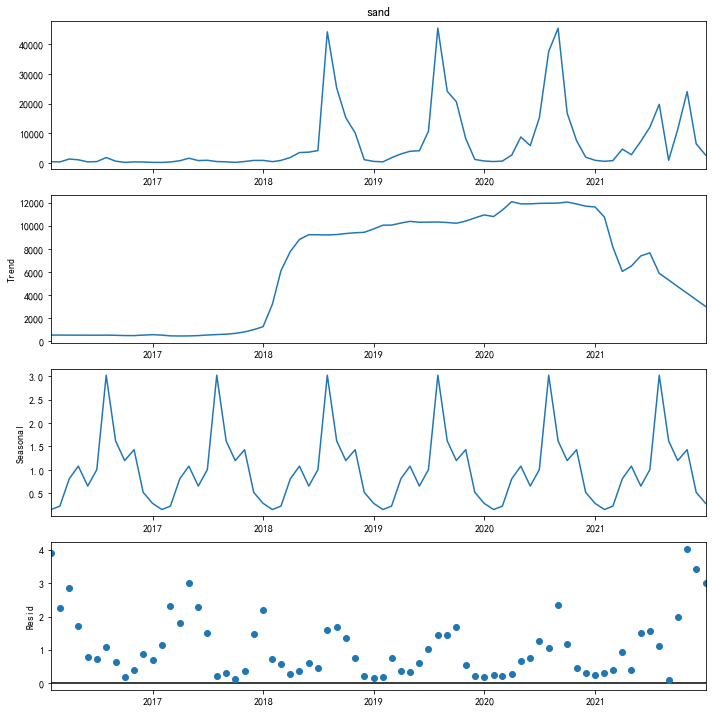

In [43]:
seasonal_mul(Df1['sand'], 'sand')

(c) 傅里叶变换检测水沙通量的周期性，研究水沙通量的变化规律

In [20]:
# 从时间序列数据中识别出幅度最大的前K个周期性成分，并返回这些周期性成分的频率和周期。
def fft(data):
    from scipy.fftpack import fft, fftfreq
    # fft函数用于计算快速傅里叶变换（FFT），fftfreq函数用于返回FFT样本频率
    fft_series = fft(data.values) # FFT将时间序列从时间域转换到频率域
    power = np.abs(fft_series) # FFT的结果是一个复数数组，表示每个频率成分的幅度和相位。这里我们只关心幅度，所以使用np.abs来计算。
    sample_freq = fftfreq(fft_series.size) # fftfreq函数返回FFT的样本频率。这些频率对应于fft_series中的每个元素。

    pos_mask = np.where(sample_freq > 0) #由于FFT的结果是对称的（对于实数输入），我们只需要考虑一半的频率成分（通常是正频率成分）。
    freqs = sample_freq[pos_mask] 
    powers = power[pos_mask]

    # 找出幅度最大的前K个频率成分:
    # 这里，np.argpartition函数用于对powers数组进行部分排序，并返回前K个最大值的索引。
    # 然后，我们使用这些索引从powers和freqs数组中提取相应的值。
    top_k_seasons = 3
    # top K=3 index
    # 由于我们关心的是周期性成分，因此我们需要计算与这些频率对应的周期。
    # 对于频率f，其周期T是1/f。这里，我们将这些周期转换为整数（四舍五入到最接近的整数周期）。
    top_k_idxs = np.argpartition(powers, -top_k_seasons)[-top_k_seasons:]
    top_k_power = powers[top_k_idxs]
    fft_periods = (1 / freqs[top_k_idxs]).astype(int)

    print(f"top_k_power: {top_k_power}")
    print(f"fft_periods: {fft_periods}")

In [44]:
fft(Df1['sand'])

top_k_power: [183840.51749344 216345.0819649  304403.33754953]
fft_periods: [14 72 12]


In [22]:
fft(Df2['flow'])

top_k_power: [16101.87230581 18475.52335785 24938.53034705]
fft_periods: [14 72 12]


## 3.3 问题3

### 根据该水文站水沙通量的变化规律，预测分析该水文站未来两年水沙通量的变化趋势，并为该水文站制订未来两年最优的采样监测方案（采样监测次数和具体时间等），使其既能及时掌握水沙通量的动态变化情况，又能最大程度地减少监测成本资源。
这里将水沙通量综合考虑为水流量

(a) 使用 SARIMA 模型对水文站未来两年水沙通量变化趋势进行预测

In [45]:
# # 导入环境中的相关包
import itertools
import numpy as np #
import pandas as pd #
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error 
from statsmodels.tsa.stattools import adfuller
import math
import seaborn as sns
import statsmodels.api as sm
#import tensorflow as tf
from pmdarima import auto_arima
#忽略警告
warnings.filterwarnings('ignore')

### 3.3.1 平稳性检验

In [80]:
#定义平稳性检验函数
def adf_val(ts, ts_title):
    # P-value是否非常接近0，接近0，则是平稳的，否则，不平稳。
    #  critical_values:1%、%5、%10不同程度拒绝原假设的统计值，
    # adf同时小于1%、5%、10%，即说明拒绝该假设
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts, autolag='t-stat')
 
    name = ['adf', 'pvalue', 'usedlag',
            'nobs', 'critical_values', 'icbest']
    values = [adf, pvalue, usedlag, nobs,
              critical_values, icbest]
    print(list(zip(name, values)))
     # 返回adf值、adf的p值、三种状态的检验值
    return adf, pvalue, critical_values, 

In [61]:
#白噪声检验也称为纯随机性检验，当数据是纯随机数据时，再对数据进行分析就没有任何意义了，所以拿到数据后最好对数据进行一个纯随机性检验。
def acorr_val(ts, lags=1):
    '''
    # 白噪声（随机性）检验
    ts: 时间序列数据，Series类型
    返回白噪声检验的P值
    '''
    # 其中lags为检验的延迟数，需要指定一个值，值的确认一般是20，或是序列长度，
    # 一般需要ljungbox_result中最小的p值大于等于0.05，才能确定这个序列是纯随机的（相当于每个p都大于等于0.05）
    aco_df = acorr_ljungbox(ts, lags, return_df=True)  # 白噪声检验结果
    return aco_df

In [200]:
# 绘制偏自相关图
def tsplot(y, name, lags=None, figsize=(14, 8)):
    # name在字符串：变量名称
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title('原时间序列')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('直方图')
    #自相关（Autocorrelation）： 对一个时间序列，现在值与其过去值的相关性。如果相关性为正，则说明现有趋势将继续保持。
    plot_acf(y, lags=lags, ax=acf_ax)
    acf_ax.set_title('自相关图')
    #fig.acf_ax.set_xlim(-1, 12)
    #可以度量现在值与过去值更纯正的相关性
    plot_pacf(y, lags=lags, ax=pacf_ax)
    pacf_ax.set_title('偏相关图')
    #fig.pacf_ax.set_xlim(-1, 12)
    #[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
 
    fig.tight_layout()
    fig.show()
    fig.figure.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/acf'+name+'.png')
    return ts_ax, acf_ax, pacf_ax

In [150]:
# 水流量数据
ts_data = Df2.astype('float32')

In [123]:
#平稳性检验
adf, pvalue1, critical_values = adf_val(ts_data, 'raw time series')
print('adf',adf)
print('pvalue1',pvalue1)
print('critical_values',critical_values)

[('adf', -0.8915925505368294), ('pvalue', 0.7907285010564606), ('usedlag', 10), ('nobs', 61), ('critical_values', {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}), ('icbest', 2.272468091402521)]
adf -0.8915925505368294
pvalue1 0.7907285010564606
critical_values {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}


In [124]:
# 平稳性检验p值>0.05，不能拒绝原假设（原假设：数据不平稳）

### 3.3.2 差分处理

季节差分：消除随着时间周期性出现的波动

In [99]:
def season_dfff(df, name):
    diff = df.diff(1)
    plt.figure(figsize=(12,4))
    plt.plot(diff)
    plt.title(name+'_diff')
    plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/Sdiff'+name+'.png')
    plt.show()

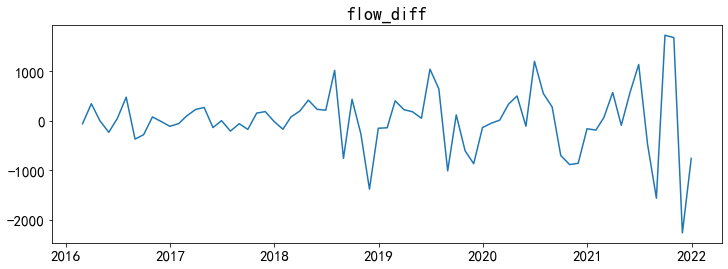

In [128]:
season_dfff(Df2, 'flow')

In [129]:
#平稳性检验
x = Df2.diff(1)
adf, pvalue1, critical_values = adf_val(x.iloc[1:,:], 'raw time series')
print('adf',adf)
print('pvalue1',pvalue1)
print('critical_values',critical_values)

[('adf', -5.526573523607566), ('pvalue', 1.827030038856164e-06), ('usedlag', 9), ('nobs', 61), ('critical_values', {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}), ('icbest', 2.46151156255067)]
adf -5.526573523607566
pvalue1 1.827030038856164e-06
critical_values {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}


In [130]:
# 一阶差分后通过了平稳性检验，但为了实现更优效果，进行二阶差分

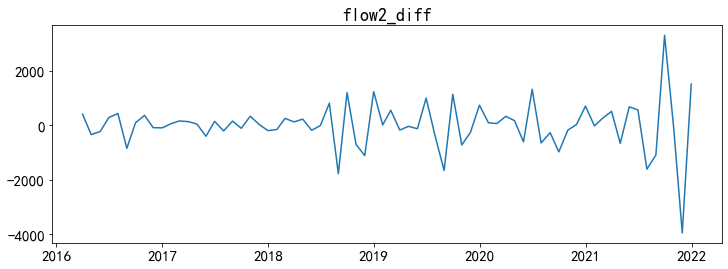

In [212]:
x = Df2.diff(1)
season_dfff(x.dropna(), 'flow2')

In [132]:
#平稳性检验
x = Df2.diff(1)
x = x.diff(1)
adf, pvalue1, critical_values = adf_val(x.iloc[2:,:], 'raw time series')
print('adf',adf)
print('pvalue1',pvalue1)
print('critical_values',critical_values)

[('adf', -6.084288784975677), ('pvalue', 1.0736407878318943e-07), ('usedlag', 9), ('nobs', 60), ('critical_values', {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}), ('icbest', 3.062351984637016)]
adf -6.084288784975677
pvalue1 1.0736407878318943e-07
critical_values {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}


### 3.3.3 随机性检验

In [170]:
# 白噪声检验
x = Df2.diff(1)
x = x.diff(1)
aco = acorr_val(x.iloc[2:,:], 12)
print('aco', aco)

aco       lb_stat  lb_pvalue
1    7.831001   0.005136
2   18.830550   0.000081
3   25.428262   0.000013
4   25.536862   0.000039
5   27.119314   0.000054
6   27.136728   0.000137
7   27.245200   0.000301
8   29.373755   0.000273
9   31.992493   0.000200
10  32.616578   0.000316
11  32.620414   0.000606
12  33.630182   0.000771


In [185]:
# 白噪声检验结果显示各阶延迟下LB统计量的P值都小于显著水平，所以拒绝序列为纯随机序列的原假设，认为该序列为非白噪声序列

### 3.3.4 建立模型

自相关和偏自相关图

(<Axes: title={'center': '原时间序列'}>,
 <Axes: title={'center': '自相关图'}>,
 <Axes: title={'center': '偏相关图'}>)

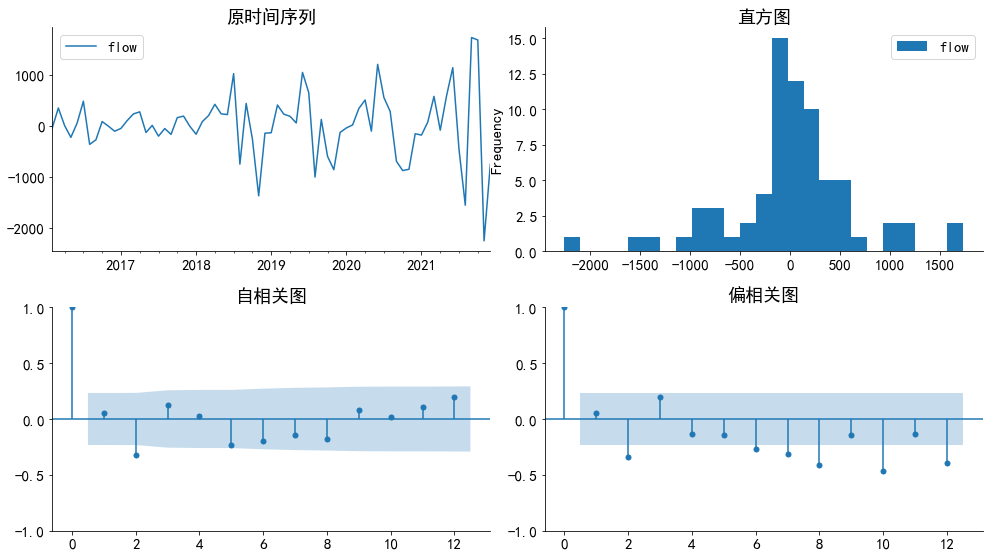

In [201]:
# 一阶差分自相关和偏自相关图
x = Df2.diff(1)
x = x.astype('float32')
tsplot(x.dropna(), 'flow', lags=12)

(<Axes: title={'center': '原时间序列'}>,
 <Axes: title={'center': '自相关图'}>,
 <Axes: title={'center': '偏相关图'}>)

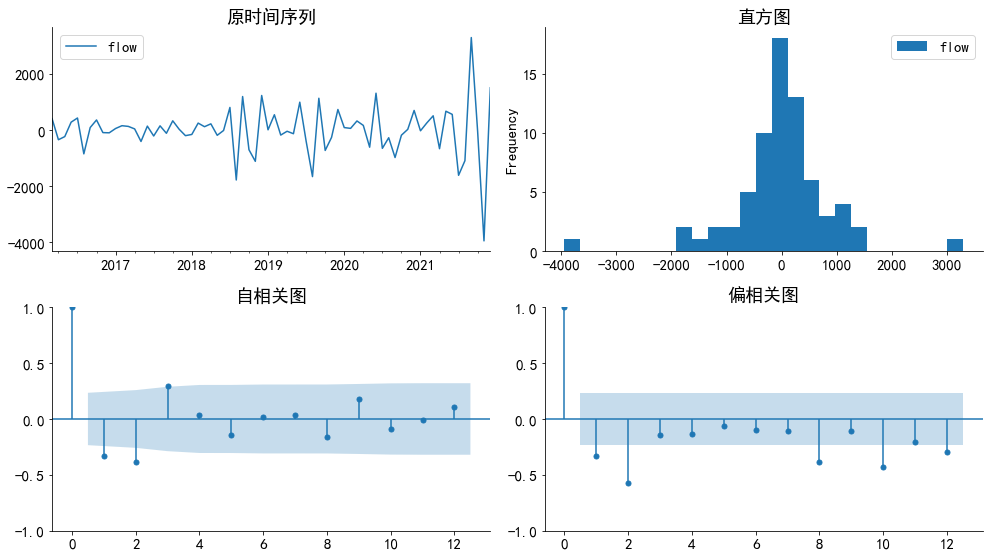

In [202]:
# 二阶差分自相关和偏自相关图
x = Df2.diff(1)
x = x.diff(1)
x = x.astype('float32')
tsplot(x.dropna(), 'flow2', lags=12)

### 3.3.4 建立模型

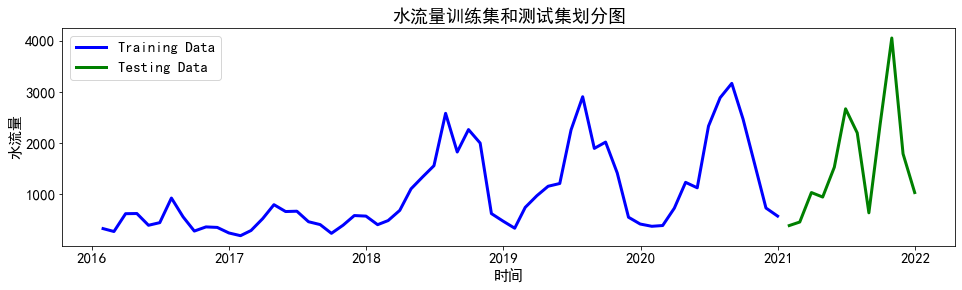

In [151]:
train_data, test_data = ts_data[0:60], ts_data[60:]
#画出训练集和测试集的原数据
plt.figure(figsize=(16,4))
plt.title('水流量训练集和测试集划分图')
plt.xlabel('时间')
plt.ylabel('水流量')
plt.plot(train_data, 'b', label='Training Data',linewidth=3)
plt.plot(test_data, 'g', label='Testing Data',linewidth=3)
font = {'serif': 'Times New Roman','size': 15}
plt.rc('font', **font)
plt.legend()
plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/train_test'+'_flow'+'.png')
plt.show()

In [171]:
#划分训练测试的数据
train_ar = train_data.values
test_ar = test_data.values 

按照AIC BIC HQIC定阶 

In [220]:
def best_sarima_model(train_data,p,q,P,Q,d=2,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))
 
                    except:
                        pass
    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models  

In [221]:
best_model, models = best_sarima_model(train_data=train_ar, p=range(4),q=range(4),P=range(3),Q=range(3))

Best model: SARIMA(0, 2, 0, 0, 1, 0, 12) AIC:738.0 BIC:740.0 HQIC:739.0 resid:inf
Best model: SARIMA(0, 2, 0, 0, 1, 2, 12) AIC:730.0 BIC:736.0 HQIC:732.0 resid:inf
Best model: SARIMA(0, 2, 0, 2, 1, 0, 12) AIC:727.0 BIC:732.0 HQIC:729.0 resid:inf
Best model: SARIMA(0, 2, 1, 0, 1, 0, 12) AIC:705.0 BIC:708.0 HQIC:706.0 resid:inf
Best model: SARIMA(0, 2, 1, 1, 1, 0, 12) AIC:704.0 BIC:709.0 HQIC:706.0 resid:inf
Best model: SARIMA(1, 2, 1, 2, 1, 1, 12) AIC:12.0 BIC:23.0 HQIC:16.0 resid:inf
Best model: SARIMA(2, 2, 1, 1, 1, 1, 12) AIC:12.0 BIC:23.0 HQIC:16.0 resid:4.947795410070755e+142


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(2, 2, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Sun, 30 Jun 2024   AIC                             12.000
Time:                                    18:46:

In [223]:
p = range(0, 4)
d = range(1, 3)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))
p = range(0, 3)
d = range(1, 3)
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print(pdq)
print(seasonal_pdq)

[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3)]
[(0, 1, 0, 6), (0, 1, 1, 6), (0, 1, 2, 6), (0, 2, 0, 6), (0, 2, 1, 6), (0, 2, 2, 6), (1, 1, 0, 6), (1, 1, 1, 6), (1, 1, 2, 6), (1, 2, 0, 6), (1, 2, 1, 6), (1, 2, 2, 6), (2, 1, 0, 6), (2, 1, 1, 6), (2, 1, 2, 6), (2, 2, 0, 6), (2, 2, 1, 6), (2, 2, 2, 6)]


按照AIC BIC定阶

In [234]:
aic = []
bic = []
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_ar,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA_param{}param_seasonal{} - AIC:{},BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            aic.append(results.aic)
            bic.append(results.bic)
            
        except:
            continue

ARIMA_param(0, 1, 0)param_seasonal(0, 1, 0, 6) - AIC:839.639638556552,BIC:841.5908822751334
ARIMA_param(0, 1, 0)param_seasonal(0, 1, 1, 6) - AIC:711.8795842785496,BIC:715.5368670715278
ARIMA_param(0, 1, 0)param_seasonal(0, 1, 2, 6) - AIC:617.7428594413818,BIC:622.8094978037236
ARIMA_param(0, 1, 0)param_seasonal(0, 2, 0, 6) - AIC:802.2491677443134,BIC:804.0778091408024
ARIMA_param(0, 1, 0)param_seasonal(0, 2, 1, 6) - AIC:663.8280550880571,BIC:667.205813996285
ARIMA_param(0, 1, 0)param_seasonal(0, 2, 2, 6) - AIC:1480.7317680846245,BIC:1485.310849658473
ARIMA_param(0, 1, 0)param_seasonal(1, 1, 0, 6) - AIC:713.9960770633885,BIC:717.6963722668086
ARIMA_param(0, 1, 0)param_seasonal(1, 1, 1, 6) - AIC:696.9261608117279,BIC:702.4120850011951
ARIMA_param(0, 1, 0)param_seasonal(1, 1, 2, 6) - AIC:611.2192900312875,BIC:617.9748078477433
ARIMA_param(0, 1, 0)param_seasonal(1, 2, 0, 6) - AIC:658.1869905567875,BIC:661.6141346901961
ARIMA_param(0, 1, 0)param_seasonal(1, 2, 1, 6) - AIC:625.2927286843692,

In [237]:
aic_min = min(aic)
aic_idx = aic.index(aic_min)
bic_min = min(bic)
bic_idx = bic.index(bic_min)
print('AIC最小的 %s ' %(aic_idx)) 
print('BIC最小的 %s ' %(bic_idx)) 

AIC最小的 383 
BIC最小的 383 


In [238]:
total = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        total.append([param, param_seasonal])

In [240]:
total[383]

[(2, 2, 1), (0, 2, 2, 6)]

先固定季节模型中的参数，再搜索其他参数

In [242]:
aic_season = []
bic_season = []
param_seasonal = [0,1,1,6]
for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_ar,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA_param{}param_seasonal{} - AIC:{},BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            aic_season.append(results.aic)
            bic_season.append(results.bic)
            
        except:
            continue

ARIMA_param(0, 1, 0)param_seasonal[0, 1, 1, 6] - AIC:711.8795842785496,BIC:715.5368670715278
ARIMA_param(0, 1, 1)param_seasonal[0, 1, 1, 6] - AIC:696.6934531058621,BIC:702.1134405751731
ARIMA_param(0, 1, 2)param_seasonal[0, 1, 1, 6] - AIC:681.6104530078643,BIC:688.7472115435373
ARIMA_param(0, 1, 3)param_seasonal[0, 1, 1, 6] - AIC:668.972244907826,BIC:677.7782454862938
ARIMA_param(0, 2, 0)param_seasonal[0, 1, 1, 6] - AIC:713.35084810479,BIC:716.9641730843306
ARIMA_param(0, 2, 1)param_seasonal[0, 1, 1, 6] - AIC:688.1049950050384,BIC:693.4575639067932
ARIMA_param(0, 2, 2)param_seasonal[0, 1, 1, 6] - AIC:673.1536641679322,BIC:680.1984646307064
ARIMA_param(0, 2, 3)param_seasonal[0, 1, 1, 6] - AIC:658.2383877388911,BIC:666.926735830308
ARIMA_param(1, 1, 0)param_seasonal[0, 1, 1, 6] - AIC:710.0312816411307,BIC:715.517205830598
ARIMA_param(1, 1, 1)param_seasonal[0, 1, 1, 6] - AIC:697.3412525690558,BIC:704.5679025281371
ARIMA_param(1, 1, 2)param_seasonal[0, 1, 1, 6] - AIC:683.9828156034359,BIC:

In [243]:
aic_min = min(aic_season)
aic_idx = aic_season.index(aic_min)
bic_min = min(bic_season)
bic_idx = bic_season.index(bic_min)
print('AIC最小的 %s ' %(aic_idx)) 
print('BIC最小的 %s ' %(bic_idx)) 

AIC最小的 7 
BIC最小的 7 


In [244]:
pdq[7]

(0, 2, 3)

按照搜索得到的参数建立模型

In [245]:
# # 构建训练数据
history = [x for x in train_ar]
print(type(history))
predictions = list()
 
#训练SARIMA模型
for t in range(len(test_ar)):
    model = sm.tsa.SARIMAX(history,order=(0,2,3), seasonal_order=(0,1,1,6),enforce_invertibility=False, enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.forecast()#模型预测
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
 
 
testScore = math.sqrt(mean_squared_error(test_ar, predictions))
print('RMSE %.3f ' %(testScore))
testScore = r2_score(test_ar, predictions)
print('R2 %.3f' %(testScore))
testScore = mean_absolute_error(test_ar, predictions)
print('MAE %.3f ' %(testScore))

<class 'list'>
predicted=709.173682, expected=391.971283
predicted=87.048501, expected=461.054352
predicted=442.151097, expected=1036.641113
predicted=1217.723129, expected=948.661377
predicted=700.009226, expected=1531.047119
predicted=1785.942395, expected=2670.947021
predicted=3317.905417, expected=2200.880859
predicted=2072.179164, expected=640.388306
predicted=199.803772, expected=2370.886963
predicted=2767.766272, expected=4053.187744
predicted=3963.901092, expected=1792.349976
predicted=1147.906607, expected=1036.025757
RMSE 1173.740 
R2 -0.282
MAE 963.296 


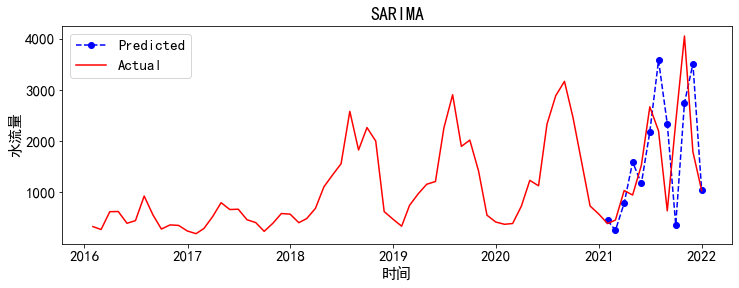

In [211]:
plt.figure(figsize=(12,4))
plt.plot(test_data.index, predictions, color='b', marker='o', linestyle='dashed',label='Predicted')
plt.plot(ts_data.index, ts_data, color='red', label='Actual')
plt.title('SARIMA')
plt.xlabel('时间')
plt.ylabel('水流量')
plt.legend()
plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/predict'+'_low'+'.png')
plt.show()

### 3.3.5 模型诊断

                                      SARIMAX Results                                      
Dep. Variable:                                flow   No. Observations:                   72
Model:             SARIMAX(2, 2, 3)x(0, 1, [1], 6)   Log Likelihood                -506.720
Date:                             Sun, 30 Jun 2024   AIC                           1027.440
Time:                                     18:31:35   BIC                           1042.553
Sample:                                 01-31-2016   HQIC                          1033.394
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3970      0.202     -1.961      0.050      -0.794      -0.000
ar.L2         -1.0000      

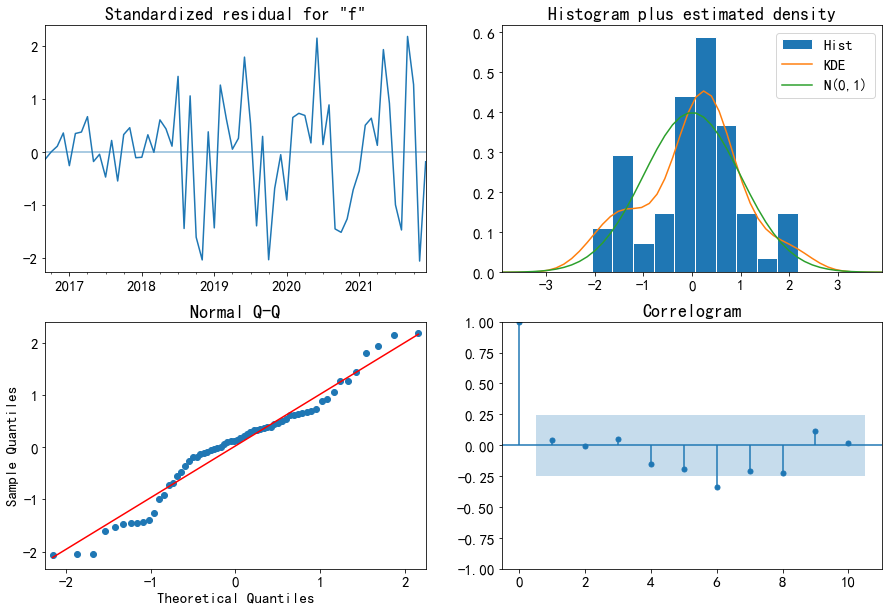

In [213]:
# 诊断
best_mod = sm.tsa.statespace.SARIMAX(ts_data.flow, order=(2,2,3), seasonal_order=(0,1,1,6))
results = best_mod.fit()
print(results.summary())
results.plot_diagnostics(figsize=(15, 10))
plt.show()

dw检验

In [ ]:
residuals = results.resid
dw_test = sm.stats.stattools.durbin_watson(residuals)
rho = 1-0.5*dw_test
rho

### 3.3.6 预测未来两年的趋势

In [214]:
pred_uc = results.get_forecast(steps=24, alpha=0.05)
pred_pr = pred_uc.predicted_mean

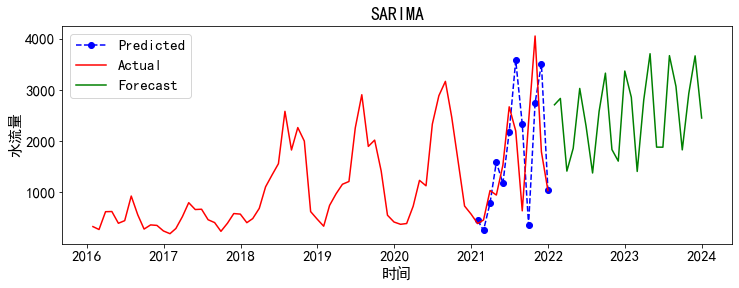

In [217]:
plt.figure(figsize=(12,4))
plt.plot(test_data.index, predictions, color='b', marker='o', linestyle='dashed',label='Predicted')
plt.plot(ts_data.index, ts_data, color='red', label='Actual')
plt.plot(pred_pr.index, pred_pr, color='green', label='Forecast')
plt.title('SARIMA')
plt.xlabel('时间')
plt.ylabel('水流量')
plt.legend()
plt.savefig('D:/CourseData/AppliedStatistics/FirstyearGraduate2/MATLAB/E题/predict'+'_twoyears'+'.png')
plt.show()